## Intro:

In this notebok we are going to  explore and example of a PyTorch end-to-end workflow. 

For reference: https://www.learnpytorch.io/01_pytorch_workflow/

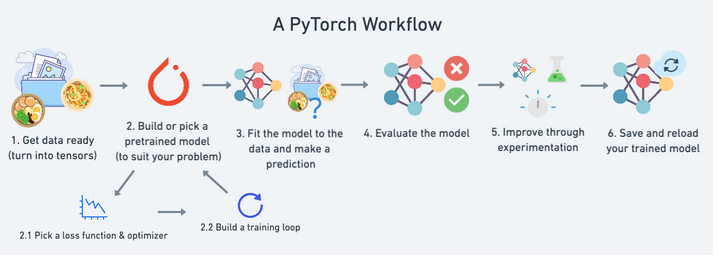

In [56]:

from IPython.display import Image, display

display(Image(filename='imgs/workflow.png', width=700))

In [57]:
import torch
from torch import nn # contains all pytorch building blocks for neural networks
import matplotlib.pyplot as plt


# check pytorch version
torch.__version__

'2.7.1+cu126'

## Prepare and load data

It can be excel spreadsheets, images of any kind, videos, audo, DNA, text...

In this notebook we are going to create some data. We'll use linear regression to create it with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

Remember that linear Regression is define by a line as --> y = m*x + b where m is weights and b is bias

In [58]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Split data into train and test

In [59]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize the data 

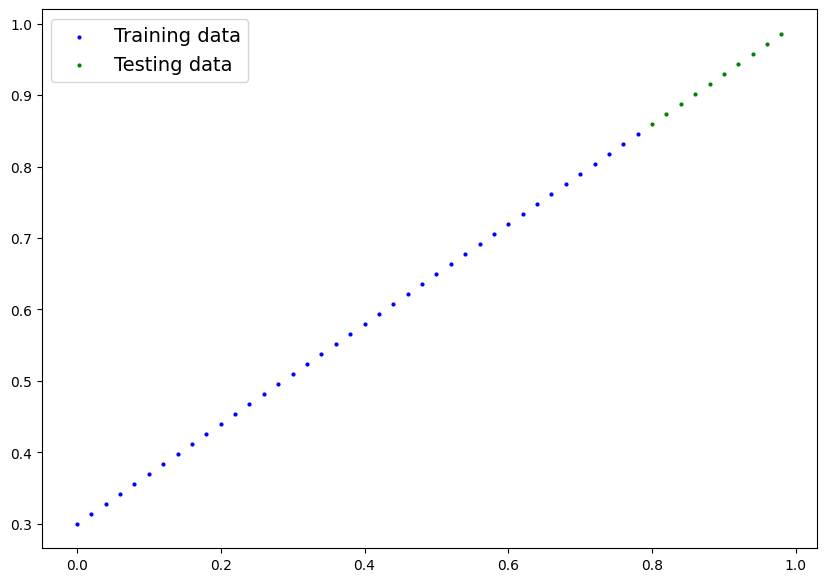

In [60]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})
  plt.show()

plot_predictions()

# Build a model

nn.Module is the **Base class** for all neural network modules. Link -> https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html

Your models should also subclass this class.

Modules can also contain other Modules, allowing them to be nested in a tree structure. 

In [61]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


The model will start with random values for weight and bias and slowly adjust them after every iteration until it gets to the most optimal prediction that represents the line above.

How does it do? Through 2 algorithms
1. Gradient Descent is an optimization algorithm that updates model parameters (like weights) by moving them in the direction that reduces the error (loss), using the gradient (slope) of the loss function. (requires_grad = True)

2. Backpropagation is the method used to compute those gradients efficiently by applying the chain rule of calculus, starting from the output layer and moving backward through the network.

## Fit the model to the data

In [62]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [63]:
# another way to see the state of the model (what the model contains) 

# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Make predictions and evaluating a model (inference)

To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

In [64]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

**Important!**
Don't use the typical y_pred = model_0(X_test). Otherwise pytorch won't keep track and predictions will take longer

link -> https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html

**Also important!**
You can also do something similar with torch.no_grad() however inference mode is preferred

link -> https://docs.pytorch.org/docs/stable/generated/torch.no_grad.html


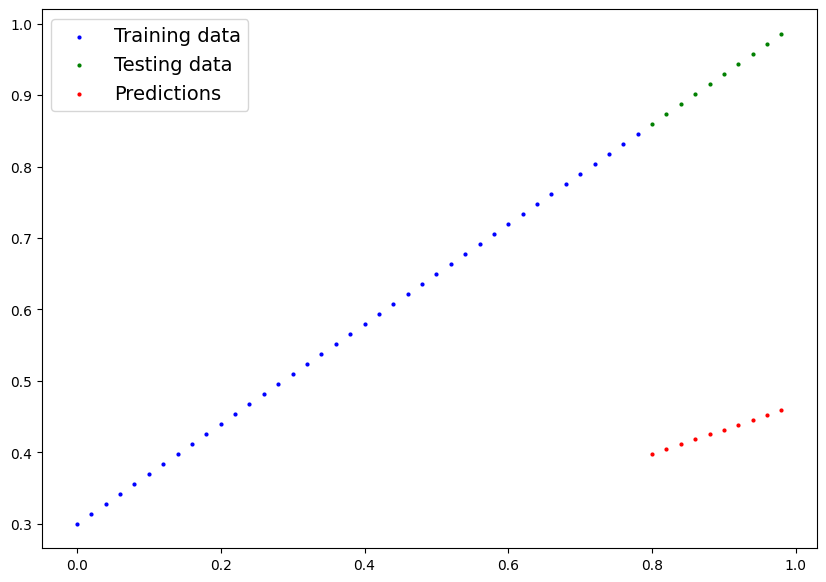

In [65]:
plot_predictions(predictions=y_preds)

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

# Train the model

To fix our mediocre model, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that are: 
1. **loss function**: Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better. PyTorch has plenty of built-in loss functions in torch.nn. Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).
2. **Optimizer**: Tells your model how to update its internal parameters to best lower the loss. You can find various optimization function implementations in torch.optim. Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).


To train the model we are going to use MAE (bc of Rregression) `nn.L1Loss()`


In [66]:
#loss function
loss_function = nn.L1Loss()

# optimizer -> https://docs.pytorch.org/docs/stable/optim.html
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

lr is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).

## Build a training (and testing) loop in PyTorch

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

### Training loop
0. Loop through the data
1. Forward pass: The model goes through all of the training data once, performing its forward() function calculations.
2. Calculate the loss: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Zero gradients: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
4. Back propagation: Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards".
5. Update optimizer: Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (gradient descent)

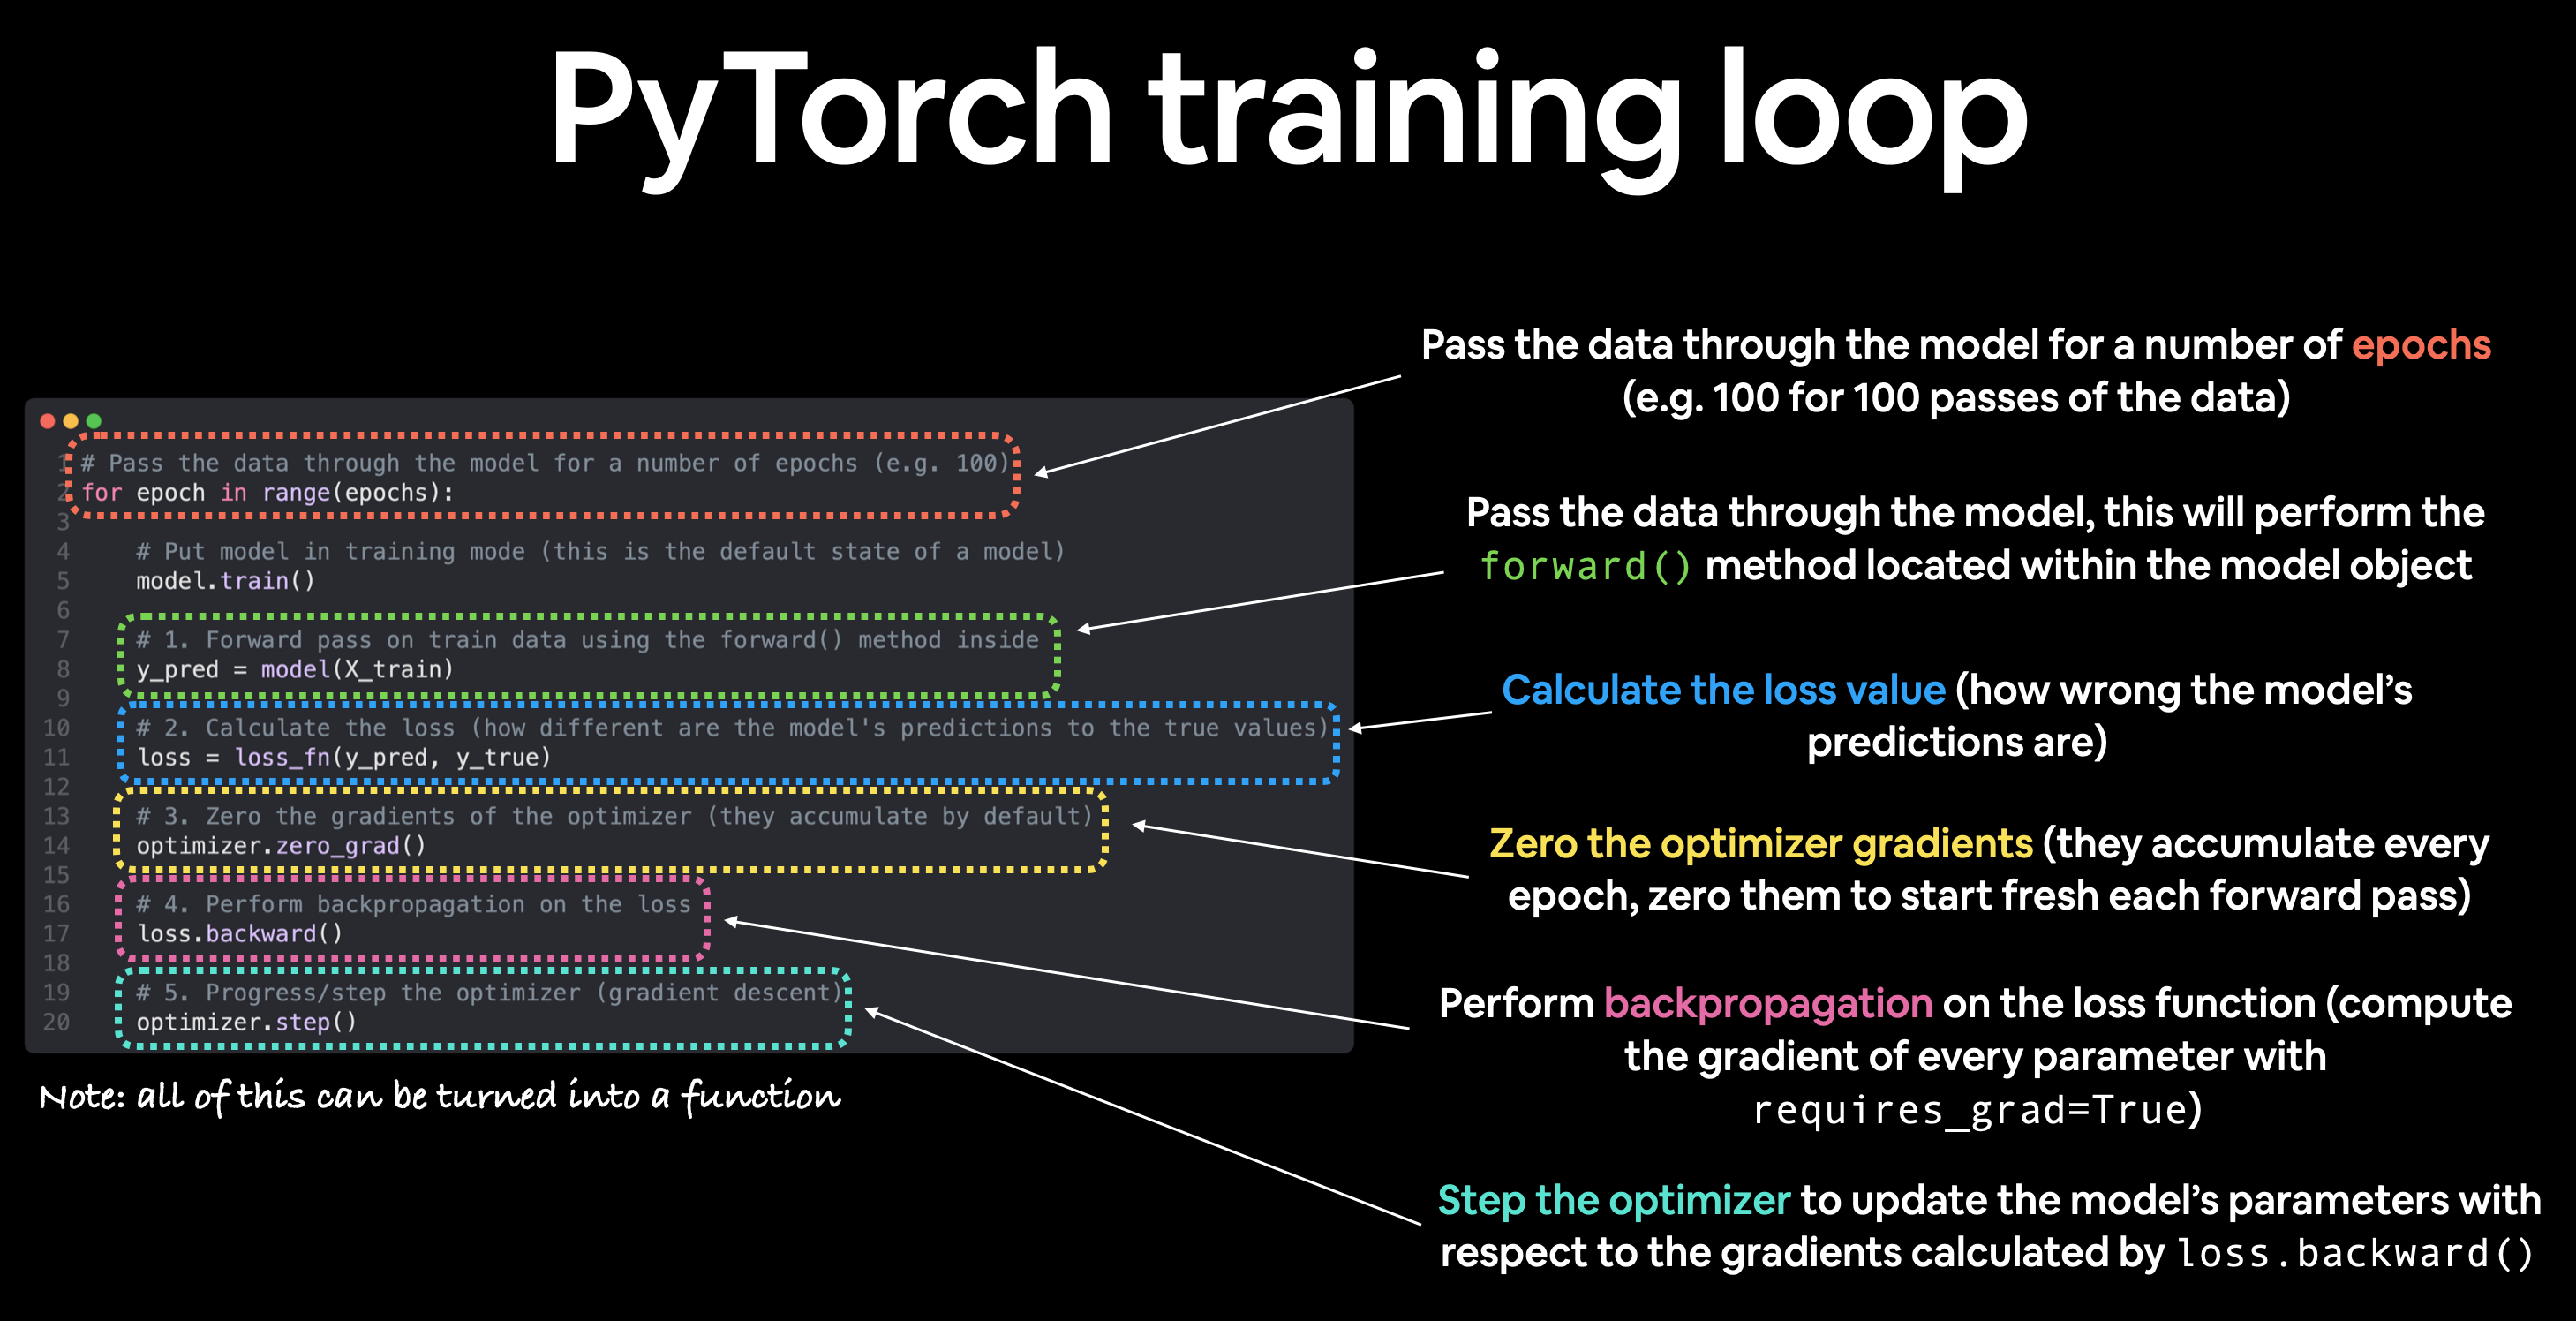

In [67]:
display(Image(filename='imgs/training_loop.png', width=1000))

### Testing loop

The testing loop doesn't contain performing backpropagation (loss.backward()) or stepping the optimizer (optimizer.step()), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.
0. Loop through the data
1. Forward pass: The model goes through all of the testing data once, performing its forward() function calculations.
2. Calculate the loss: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. Calculate the evaluation metrics (optional): Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.

In [68]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
    loss = loss_function(y_pred, y_train)

    # 3. The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.
    optimizer.zero_grad()

    # 4. Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True).
    # This is known as backpropagation, hence "backwards".
    loss.backward()

    # 5. Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. The model goes through all of the testing data once, performing its forward() function calculations.
      test_pred = model_0(X_test)

      # 2. The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
      test_loss = loss_function(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set.
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


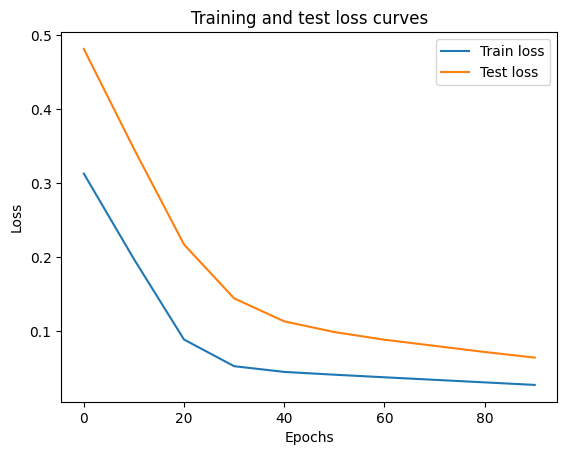

In [69]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [70]:


# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")



The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


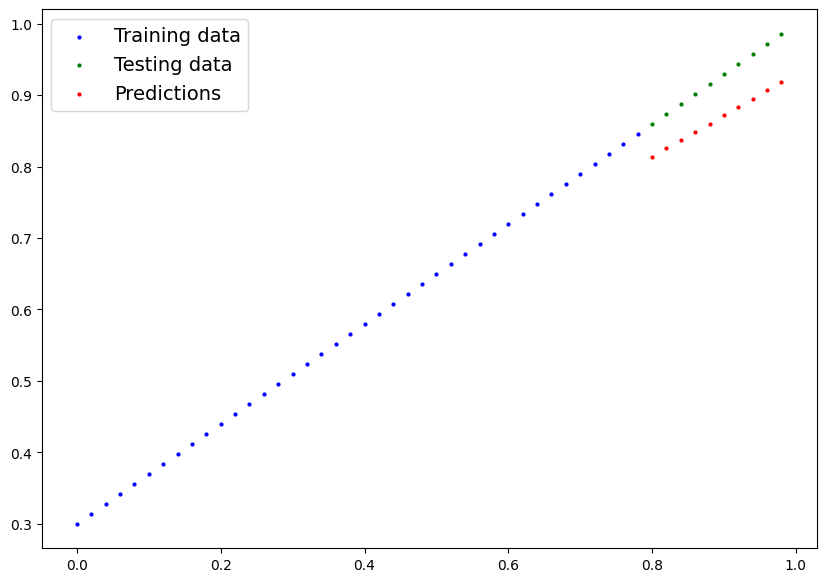

In [71]:
plot_predictions(predictions=test_pred)

# Saving and loading a PyTorch model

link -> https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

For saving and loading models in PyTorch, there are three main methods you should be aware of:
1. torch.save: Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save
2. torch.save : Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

3. torch.nn.Module.load_state_dict: Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

### Saving a PyTorch model's state_dict()

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called models using Python's pathlib module.
2. We'll create a file path to save the model to.
3. We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

Note: It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.


In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

## Loading a saved PyTorch model's state_dict()

In [ ]:
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

y_preds == loaded_model_preds

## Putting it all together